## LangGraph: Multi-Agent Workflows tutorial

### Multi-agent supervisor

Using an LLM to orchestrate the different agents.

![multi agent collaboration flowchart](images/multi-agent-collaboration.png)


### Create Tools
In this case, an agent to do web research with a search engine, and another to create plots. These two agents will make use of the tools below

In [1]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# this tool can be unsafe because code is executed locally
python_repl_tool = PythonREPLTool()

### Helper Utilities
A helper function to create nodes in the graph. It converts the agent response to a human message, which is important when adding it to the global state of the graph.

In [2]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

### Create Supervisor Agent

Use function calling to choose the next worker node or to finish processing

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal, List, Tuple

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    "following workers: {members}. Given the following user request,"
    "respond with the worker to act next. Each worker will perform a"
    "task and respond with their results and status. When finished ,"
    "respond with FINISH"
) 

options = ["FINISH"] + members

# if using python version >= 3.11
# class routeResponse(BaseModel):
#     next: Literal[*options]

class routeResponse(BaseModel):
    next: Literal["FINISH", "Researcher", "Coder"]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            "Or should we FINISH? Select on of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-3.5-turbo")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

### Graph Construction

In [4]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

#  The AgentState is the input to each node in the graph
class AgentState(TypedDict):
    # This annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicated where to route to next
    next: str

research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("Supervisor", supervisor_agent)

Next, we connect the edges

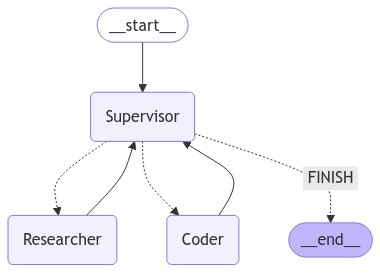

In [5]:
from IPython.display import Image, display

for member in members:
    # We always want our workers to report back to the supervisor when done
    workflow.add_edge(member, "Supervisor")
# assume the supervisor populates the "next" field in the graph state which routes either to the next node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

# setup the conditions for travelling to each agent by checking the "next" field that is populated by the supervisor agent
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

# add the entrypoint to thee workflow
workflow.add_edge(START, "Supervisor")

graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

### Testing Code Agent

In [6]:
from rich import print as rprint

for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        rprint(s)
        rprint("----")

{'Supervisor': {'next': 'Coder'}}

----

Python REPL can execute arbitrary code. Use with caution.


{
    'Coder': {
        'messages': [
            HumanMessage(
                content='The code "Hello, World!" has been printed to the terminal.',
                additional_kwargs={},
                response_metadata={},
                name='Coder'
            )
        ]
    }
}

----

{'Supervisor': {'next': 'FINISH'}}

----

### Testing Research Agent 

In [7]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas and then print it out to the terminal")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        rprint(s)
        rprint("----")

{'Supervisor': {'next': 'Researcher'}}

----

{
    'Researcher': {
        'messages': [
            HumanMessage(
                content="### Research Report on Pikas\n\n#### Population Trajectory of American Pikas:\nA study 
conducted at Bodie State Historic Park, California, tracked the population trajectory of American pikas from 1972 
to 2022. This research provides insights into how American pikas are responding to climate change, offering a 
comprehensive portrayal of the species' population trends over time.\n\n#### Habitat Resilience of American 
Pikas:\nResearchers found that American pikas in mountain habitats remained resilient to climate changes. The study
measured diurnal and seasonal temperatures of pikas' rocky talus habitats in the Great Basin of the U.S. The 
findings highlighted the ability of pikas to adapt to their environments and maintain stable habitats despite 
external temperature variations.\n\n#### Climate Impact on Pika Distribution:\nStudies have shown that climate 
change is affecting the distribution of American pikas across the Western U.S. Some locations are experiencing pika
losses due to changes in temperature and precipitation patterns. The research emphasizes the variability in pika 
populations and the nuanced influence of climate on their habitats.\n\n#### Conservation Concerns for Pikas:\nAs 
snowpack declines and habitats become more isolated, researchers predict a significant drop in the occupancy of 
pika habitats. Conservation efforts are crucial to protect the remaining pika populations, especially in areas like
Craters of the Moon National Monument and Preserve, where environmental factors pose challenges to the species' 
survival.\n\nFor more detailed information and research findings on American pikas, you can refer to the following 
sources:\n1. [Fifty-year population trajectory in a marginal American Pika 
population](https://research.fs.usda.gov/treesearch/68198)\n2. [American Pika: Model of Resilience to Climate 
Vulnerability](https://research.fs.usda.gov/psw/news/highlights/american-pika-icon-climate-vulnerability-model-resi
lience)\n3. [Pikas: Status, Resilience, and 
Conservation](https://academic.oup.com/jmammal/article/101/6/1466/5917619)\n4. [Pikas Disappearing in Parts of the 
West due to Climate 
Change](https://www.usgs.gov/news/national-news-release/pikas-disappearing-parts-west-due-climate-change)\n5. 
[Pikas in Peril: Conservation Challenges and Predictions](https://www.nps.gov/orgs/1778/pikas-in-peril.htm)\n\nThis
research report highlights the importance of understanding and conserving American pikas in the face of climate 
change and environmental challenges.",
                additional_kwargs={},
                response_metadata={},
                name='Researcher'
            )
        ]
    }
}

----

{'Supervisor': {'next': 'Coder'}}

----

{
    'Coder': {
        'messages': [
            HumanMessage(
                content='The research report on pikas has been successfully printed out to the terminal. If you 
need any further assistance or modifications, feel free to let me know!',
                additional_kwargs={},
                response_metadata={},
                name='Coder'
            )
        ]
    }
}

----

{'Supervisor': {'next': 'FINISH'}}

----